In [1]:
from datetime import datetime
import backtrader as bt
import quantstats as qs
import pandas as pd
import csv

In [2]:
class CashMarket(bt.analyzers.Analyzer):
  def start(self):
    super(CashMarket, self).start()

  def create_analysis(self):
    self.rets = {}
    self.vals = 0.0

  def notify_cashvalue(self, cash, value):
    self.vals = (cash, value)
    self.rets[self.strategy.datetime.datetime().strftime("%Y-%m-%d")] = self.vals

  def get_analysis(self):
    return self.rets

class SmaCross(bt.Strategy):
  params = dict(
    pfast=5,
    pslow=30
  )

  def __init__(self):
    sma1 = bt.ind.SMA(period=self.p.pfast)
    sma2 = bt.ind.SMA(period=self.p.pslow)
    self.crossover = bt.ind.CrossOver(sma1, sma2)

  def next(self):
    if not self.position:  # not in the market
      if self.crossover > 0:
        self.buy()

    elif self.crossover < 0:  # in the market & cross to the downside
      self.close()

In [3]:
cerebro = bt.Cerebro()

In [4]:
data = bt.feeds.YahooFinanceCSVData(
        dataname='yhoo-1996-2014.txt',
        # Do not pass values before this date
        fromdate=datetime(2000, 1, 1),
        # Do not pass values before this date
        todate=datetime(2002, 12, 31),
        # Do not pass values after this date
        reverse=False)

In [5]:
cerebro.adddata(data)
cerebro.addstrategy(SmaCross)
cerebro.addanalyzer(CashMarket, _name='cashmarket')
results = cerebro.run()

In [6]:
# ---- Format the values from results ----
df_values = pd.DataFrame(results[0].analyzers.getbyname("cashmarket").get_analysis()).T
df_values = df_values.iloc[:, 1]
returns = qs.utils.to_returns(df_values)
returns.index = pd.to_datetime(returns.index)
# ----------------------------------------

In [7]:
# ---- Format the benchmark from SPY.csv ----
with open('SPY.csv', mode='r') as infile:
  reader = csv.reader(infile)
  mydict = {
    datetime.strptime(rows[0], "%Y-%m-%d"): float(rows[4]) for rows in reader
  }

benchmark = (
  pd.DataFrame.from_dict(mydict, orient="index")
)
returns_bm = qs.utils.to_returns(benchmark)
returns_bm.index = pd.to_datetime(returns_bm.index)
# -------------------------------------------

In [8]:
#qs.extend_pandas()

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-01-03  2000-01-03
End Period                 2002-12-30  2002-12-30
Risk-Free Rate             0.0%        0.0%
Time in Market             39.0%       0.0%

Cumulative Return          -0.42%      0.0%
CAGR%                      -0.14%      0.0%
Sharpe                     -0.98       nan
Sortino                    -1.2        nan
Max Drawdown               -0.46%      nan%
Longest DD Days            -           -
Volatility (ann.)          0.14%       0.0%
R^2                        0.0         0.0
Calmar                     -0.3        nan
Skew                       -2.11       0.0
Kurtosis                   27.61       0.0

Expected Daily %           -0.0%       0.0%
Expected Monthly %         -0.01%      0.0%
Expected Yearly %          -0.14%      0.0%
Kelly Criterion            nan%        nan%
Risk of Ruin               0.0%        1.0%
Daily Value-at-

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2000-03-28,2001-07-11,2002-12-30,1007,-0.462527,-0.459128
2,2000-03-10,2000-03-15,2000-03-27,17,-0.113400,-0.062100


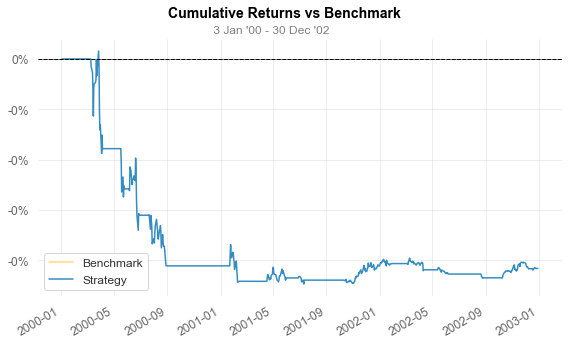

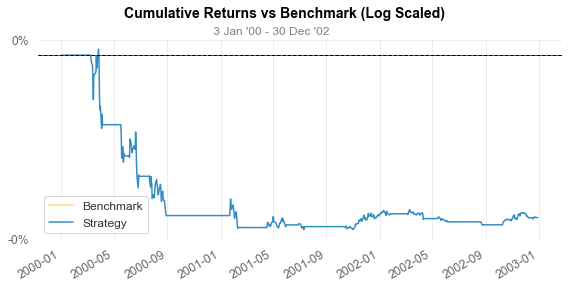

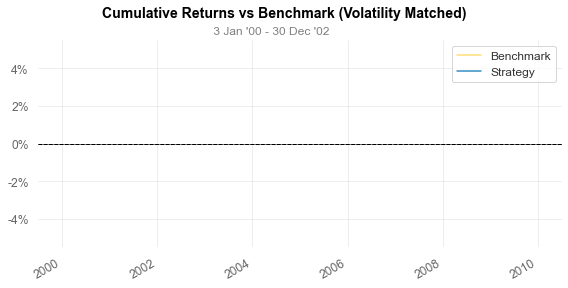

aap test before yearly returns
type(returns) = <class 'pandas.core.series.Series'>
type(returns.index) = <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
aap test before plot_returns_bars
type(returns) = <class 'pandas.core.series.Series'>
type(returns.index) = <class 'pandas.core.indexes.numeric.Int64Index'>
aap test start of plot return
type(returns) = <class 'pandas.core.series.Series'>
type(returns.index) = <class 'pandas.core.indexes.numeric.Int64Index'>
aap test after df creation. df:
      Strategy
2000 -0.004109
2001 -0.000007
2002 -0.000044
type(df) = <class 'pandas.core.frame.DataFrame'>
type(df.index) = <class 'pandas.core.indexes.numeric.Int64Index'>
aap test after df.dropna. df:
Empty DataFrame
Columns: [Benchmark, Strategy]
Index: []
aap testing in subtitle
Empty DataFrame
Columns: [Benchmark, Strategy]
Index: []
type(df) = <class 'pandas.core.frame.DataFrame'>
type(df.index) = <class 'pandas.core.indexes.numeric.Int64Index'>


IndexError: index 0 is out of bounds for axis 0 with size 0

In [9]:
qs.reports.full(returns, returns_bm)

In [10]:
returns.index.date[:1][0]

datetime.date(2000, 1, 3)

In [13]:
groupby = returns.index.year
newdf = returns.groupby(groupby).sum()
newdf

2000   -0.004115
2001   -0.000007
2002   -0.000044
Name: 1, dtype: float64

In [10]:
#defaults of plot_returns_bars
returns_label="Strategy"
resample=None
subtitle=True
benchmark=returns_bm

In [15]:
df = pd.DataFrame(index=newdf.index, data={returns_label: newdf})
df

,Strategy
2000,-0.004115
2001,-0.000007
2002,-0.000044


In [ ]:
if isinstance(benchmark, pd.Series):
    df['Benchmark'] = benchmark[benchmark.index.isin(returns.index)]
    df = df[['Benchmark', returns_label]]

In [16]:
df = df.dropna()

In [17]:
if resample is not None:
        df = df.resample(resample).apply(qs.stats.comp).resample(resample).last()
df

,Strategy
2000,-0.004115
2001,-0.000007
2002,-0.000044


In [18]:
df.index

Int64Index([2000, 2001, 2002], dtype='int64')

In [19]:
print("\n%s - %s                   " % (
            # df.index.date[:1][0].strftime('%Y'),
            # df.index.date[-1:][0].strftime('%Y')
            pd.to_datetime(df.index.values[:1][0]).strftime('%Y'),
            pd.to_datetime(df.index.values[-1:][0]).strftime('%Y')
        ))


1970 - 1970                   


In [11]:
groupby = returns.index.year
newdf = returns.groupby(groupby).sum()
newdf

2000   -0.004115
2001   -0.000007
2002   -0.000044
Name: 1, dtype: float64

In [13]:
newdf.index[0]

2000

In [14]:
newdf.index[-1]

2002

In [21]:
returns.index[0]

'2000'